In [1]:
import sqlite3
# Create a connection to the database
conn = sqlite3.connect('experiment.db')


/var/folders/jv/cyyhkkf51sz8tztbvyfqbgvc0000gn/T/ipykernel_14499/1539245177.py:100: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = df.pivot_table(


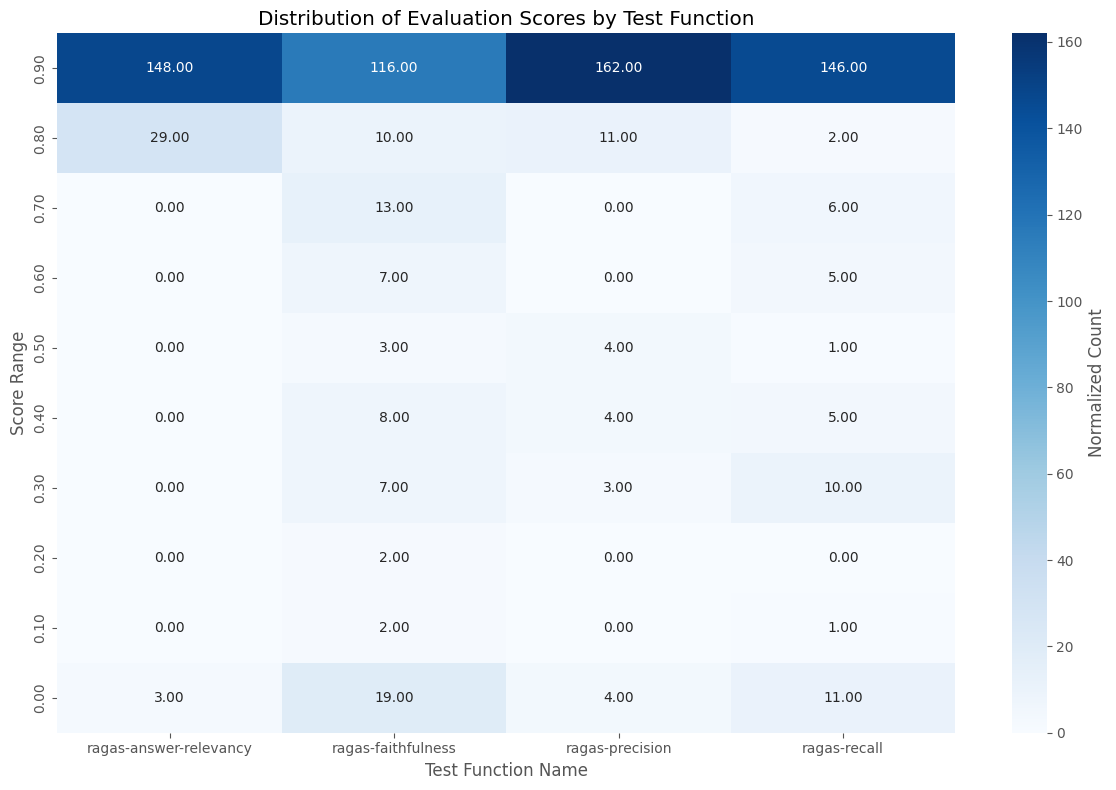

Summary Statistics:
                        count      mean       std  min       25%       50%  \
eval_function_name                                                           
ragas-answer-relevancy  187.0  0.932847  0.127348  0.0  0.922838  0.956788   
ragas-faithfulness      187.0  0.793628  0.332804  0.0  0.666667  1.000000   
ragas-precision         188.0  0.938830  0.188292  0.0  1.000000  1.000000   
ragas-recall            187.0  0.869315  0.283188  0.0  1.000000  1.000000   

                             75%  max  
eval_function_name                     
ragas-answer-relevancy  0.986779  1.0  
ragas-faithfulness      1.000000  1.0  
ragas-precision         1.000000  1.0  
ragas-recall            1.000000  1.0  


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def get_data(conn):
    query = """
    SELECT 
        re.test_run_id,
        tr.description as test_run_name,
        re.question_id,
        q.question as question_content,
        re.response_id,
        r.response as response_content,
        re.test_eval_config_id,
        re.eval_score,
        ef.name as eval_function_name
    FROM response_evals re
    JOIN test_runs tr ON re.test_run_id = tr.id
    JOIN questions q ON re.question_id = q.id
    JOIN responses r ON re.response_id = r.id
    JOIN test_eval_configs tec ON re.test_eval_config_id = tec.id
    JOIN eval_functions ef ON tec.eval_function_id = ef.id
    """
    return pd.read_sql_query(query, conn)

def analyze_data2(df):
    # Basic statistics
    print("Basic Statistics:")
    print(df['eval_score'].describe())
    
    # Average score by test run and evalfunction
    avg_by_config = df.groupby(['test_run_name', 'eval_function_name'])['eval_score'].mean().sort_values(ascending=False)
    print("\nAverage Score by Eval Config:")
    print(avg_by_config)

    # Boxplot of scores by test run and eval function
    df.boxplot(column='eval_score', by=['test_run_name', 'eval_function_name'], rot=90)
    plt.title('Boxplot of Evaluation Scores by Test Run and Eval Function')
    plt.suptitle('')
    plt.ylabel('Score')
    plt.show()

def analyze_data3(df):
    # Set the style for all plots
    plt.style.use('seaborn')

    # 2. Box plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='eval_function_name', y='eval_score', data=df)
    plt.title('Box Plot of Scores by Evaluation Function')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('box_plot.png')
    plt.close()

    # 3. Kernel Density Estimation (KDE) plot
    plt.figure(figsize=(12, 6))
    for func in df['eval_function_name'].unique():
        sns.kdeplot(df[df['eval_function_name'] == func]['eval_score'], shade=True, label=func)
    plt.title('Kernel Density Estimation of Scores by Evaluation Function')
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.savefig('kde_plot.png')
    plt.close()

    # 4. Heatmap of average scores
    pivot_df = df.pivot_table(values='eval_score', index='test_run_name', 
                              columns='eval_function_name', aggfunc='mean')
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title('Heatmap of Average Scores by Test Run and Evaluation Function')
    plt.tight_layout()
    plt.savefig('heatmap.png')
    plt.close()

    # 5. Summary statistics
    summary_stats = df.groupby('eval_function_name')['eval_score'].describe()
    summary_stats.to_csv('summary_statistics.csv')
    print("Summary Statistics:")
    print(summary_stats)

def analyze_data(df):
    # Set the style for all plots
    plt.style.use('ggplot')

    
    # Heatmap of scores by test function
    # Create score bins
    decimal_precision = 2
    score_bins = np.round(np.linspace(0, 1, 11), decimal_precision)
    bin_labels = [f"{score:.{decimal_precision}f}" for score in score_bins[:-1]]

    df['score_bin'] = pd.cut(df['eval_score'], bins=score_bins, labels=bin_labels, include_lowest=True)

    # Create a pivot table
    pivot_data = df.pivot_table(
        values='eval_score', 
        index='score_bin', 
        columns='eval_function_name', 
        aggfunc='count',
        fill_value=0
    ).sort_index(ascending=False)

    # Normalize the data (optional, but helps in visualizing the distribution)
    #pivot_data_normalized = pivot_data.div(pivot_data.sum(axis=0), axis=1)

    # Create the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_data, cmap="Blues", annot=True, fmt='.2f', cbar_kws={'label': 'Normalized Count'})

    plt.title("Distribution of Evaluation Scores by Test Function")
    plt.xlabel("Test Function Name")
    plt.ylabel("Score Range")
    plt.tight_layout()
    plt.show()

    # 5. Summary statistics
    summary_stats = df.groupby('eval_function_name')['eval_score'].describe()
    summary_stats.to_csv('summary_statistics.csv')
    print("Summary Statistics:")
    print(summary_stats)

df = get_data(conn)
analyze_data(df)